<a id="top"></a>
# NLP Hotel Review Classification
---
### *Notebook 1/3: Data Cleaning & EDA*
---

**Project Outline**: 


A multi-class classification project utilising natural language processing techniques to classify hotel reviews (ratings 1 - 5) from the popular travel booking site TripAdvisor. After scraping reviews from TripAdvisor and combining them with existing data, I cleaned and preprocessed them before building several different models that attempted to predict the rating of the reviews. The best model turned out to be BERT (Bidirectional Encoder Representations from Transformers), a pretrained model that had an accuracy of 62% on the test set.

## Contents
---

**1.  [Overview](#overview)** <br>
**2.  [Statistical Summary of Models](#statistical_summary)** <br>
**3.  [Data Reading & Checking](#data_checking)** <br>
**4.  [Data Cleaning & EDA](#data_cleaning_eda)** <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**4.1.  [Tokenization](#tokenization)** <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**4.2.  [Lemmatization](#lemmatization)** <br>

<a id="overview"></a>
## 1. Overview
---

**Problem Statement**

Today, reviews form a big part of society and many people rely heavily on them when making decisions about purchasing goods and services. Reviews not only help to inform people but they can also be extremely useful for identifying where businesses need to improve. Because of this, businesses often encourage people to leave reviews and ratings of their products or services. 

While many people do leave reviews and ratings, many others share their thoughts and feelings about particular goods and services in a variety of different public places, such as forums, blogs or even through social media channels.

Given the usefulness of this feedback, it could be beneficial for a business to develop a methodology to find these reviews and attempt to estimate what rating that person would have given for the good or service that they recieved. 

Processing textual information like this could give businesses a more comprehenisve understanding of how their products and services are perceived by consumers which could help them make critical business decisions.

---

**Obtaining the Reviews**

- While I was able to find some existing review data from TripAdvisor on Kaggle, the data was heavily imbalanced in favour of higher ratings. Because of this, I built a script using BeautifulSoup and Selenium to scrape reviews from the TripAdvisor website. When looking for hotels to scrape, I focused on big capital cities that usually have a lot of hotel guests throughout the year. I picked London, Paris and Berlin and tried to find hotels that had a good mix of positive and negative reviews. Despite this, most of the ratings for the majority of hotels were either a 4 or 5. In total, I scraped reviews from 33 hotels, 11 from each city.


**Splitting the Notebooks**

- Given the computational resources required for training, much of the model building in this project was carried out on Google Colab.


**Deployment**

- After finding a model that performed reasonably well, I deployed it as an app using Streamlit. The app, which allows users to enter a review and receive a predicted rating for it, can be found at XXXX.

<a id="statistical_summary"></a>
## 2. Statistical Summary of Models
---

Include table with all of the regular algorithms.

Include table with the 3 neural networks and the pretrained model.

<a id="data_checking"></a>
## 3. Data Reading & Checking
---

In [1]:
# Imports
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from helper_functions import clean_reviews, create_wordcloud, plot_word_count, top_words
import string
from wordcloud import WordCloud
from collections import Counter
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

# Set plot style
sns.set(style='darkgrid', palette='muted')

In [2]:
# View all filepaths in data directory
filepaths = []
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        filepaths.append(os.path.join(dirname, filename))
filepaths

['data/kaggle_tripadvisor_hotel_reviews.csv',
 'data/scraped_tripadvisor_hotel_reviews.csv']

In [3]:
# Extract filepaths that contain hotel reviews
hotel_reviews = [f for f in filepaths if "hotel" in f]

As we have two sources of data containing reviews from TripAdvisor, we will read the data in and then concatentate them.

In [4]:
# Read data
df1 = pd.read_csv(hotel_reviews[0])
df2 = pd.read_csv(hotel_reviews[1])

In [5]:
# Concatenate dataframes
df = pd.concat([df1, df2], axis=0, ignore_index=True)

In [6]:
# Check data
df

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
48443,Hotel Itself.Three of us stayed in three rooms...,4
48444,We stayed here in late January 2006. We found ...,3
48445,To be honest we booked this hotel because it w...,4
48446,If you are looking for a mid to low range hote...,3


In [7]:
# Check info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48448 entries, 0 to 48447
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  48448 non-null  object
 1   Rating  48448 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 757.1+ KB


In [8]:
# Rating score frequency
df['Rating'].value_counts()

5    18721
4    15025
3     6551
1     4316
2     3835
Name: Rating, dtype: int64

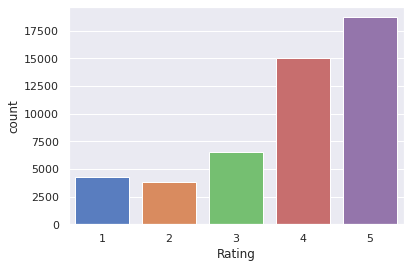

In [9]:
# Plot rating score frequencies
sns.countplot(x=df['Rating']);

Here, we can see that we have a high class imbalance, with the majority of reviews recieving a rating of either 4 or 5.

In [10]:
# Rating score percentages
round(df['Rating'].value_counts()/df.shape[0]*100,2)

5    38.64
4    31.01
3    13.52
1     8.91
2     7.92
Name: Rating, dtype: float64

Combined, ratings of 4 or 5 total just under 70% of the entire data.

In [11]:
# Check for null values
df.isnull().sum()

Review    0
Rating    0
dtype: int64

It looks like we have no missing values.

In [12]:
# Look at an example of a review
df['Review'][2]

"nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathroom mediterranean suite comfortable bed pillowsattentive housekeeping staffnegatives ac unit malfunctioned stay desk disorganized, missed 3 separate wakeup calls, concierge busy hard touch, did n't provide guidance special requests.tv hard use ipod sound dock suite non functioning. decided book mediterranean suite 3 night weekend stay 1st choice rest party filled, comparison w spent 45 night larger square footage room great soaking tub whirlpool jets nice shower.before stay hotel arrange car service price 53 tip reasonable driver waiting arrival.checkin easy downside room picked 2 person jacuzi tub no bath accessories salts bubble bath did n't stay, night got 12/1a checked voucher bottle champagne nice gesture fish waiting room, impression room huge open space felt room big, tv far away bed chore change channel, ipod dock broken disappointing.in morning way asked desk check thermostat said 6

Here we can see that the review is quite messy. Amongst other things, it contains numerical data and special characters which usually do not add any additional information. Let's clean the reviews and move onto the EDA phase.

<a id="data_cleaning_eda"></a>
## 4. Data Cleaning & EDA

In [13]:
# Create set of stop words
stop_words = set(stopwords.words('english'))

In [14]:
# Add single characters and numerical suffixes to list of stop words
all_chars = []
all_chars[:] = string.ascii_lowercase # All individual characters
stop_words.update(all_chars) # Update stop_words with all individual characters
stop_words.update(['st', 'nd', 'rd', 'th']) # Update with suffixes after numbers e.g. 1st, 2nd, 3rd, 4th

In our reviews, there are also many words that are very common and do not add much information. To remove these common words, we will use NLTK's predefined list of stop words and add to them some of our own. In particular, we will add all individual characters (lowercase and uppercase) as well as common numerical suffixes such as the 'st' from 1st.

In [15]:
# Remove some words from stop words set that imply sentiment
not_stopwords = {
    "aren", "aren't", "couldn", "couldn't", "didn", "didn't", "doesn", "doesn't", "don", "don't", "hadn", 
    "hadn't", "hasn", "hasn't", "haven", "haven't", "isn", "isn't", "mustn", "mustn't", "no", "not", "only",
    "shouldn", "shouldn't", "should've", "wasn", "wasn't", "weren", "weren't", "will", "wouldn", "wouldn't", 
    "won't", "very",  
} 
stop_words = set([word for word in stop_words if word not in not_stopwords])
print(stop_words)

{'ma', 'too', 'again', 'now', 'those', "shan't", 'here', 'w', 'x', 'and', 'so', 'e', 'theirs', "it's", 'can', 'or', 'below', 'needn', 'h', 'a', 'down', 'o', 'been', 've', 'up', 'further', 'should', 'q', "you're", 'some', 'any', 'with', 'yours', 'our', 'shan', 'same', 'yourself', 'of', 'do', 'to', "you've", 'the', 'than', 'its', 'myself', 'who', 'have', 'itself', 'that', 'this', 'each', 'where', 'by', 'about', 'doing', 'hers', 'v', 'did', 'both', 'before', 'rd', 'these', 'between', 're', 'then', 'over', 'an', 'few', 'z', 'are', 'into', 'your', 'p', 's', 'u', 'you', 'such', 'why', 'while', 'was', 'himself', 'st', 'nor', 'm', 'k', 't', 'her', 'through', 'him', 'after', 'were', 'nd', 'b', 'his', 'am', 'which', 'had', 'g', 'when', 'does', "you'll", "she's", 'as', 'from', 'they', 'once', 'against', 'has', 'above', 'my', 'th', 'until', 'we', 'for', 'c', 'mightn', 'ain', 'l', 'f', 'their', 'whom', 'all', 'just', "mightn't", 'herself', 'ourselves', 'under', 'having', 'be', 'ours', 'r', 'if', 'b

While the predefined list includes many common words that do not add any additonal information, they also contain common words that might be useful in determining what rating a review is likely to give. Because of this, we will remove some of the words from the stop words list that could help in determining the rating.

To make cleaning the reviews easier, I created a simple function that converts reviews to lowercase, removes all digits and special characters, and then removes all of the stop words we have defined.

In [16]:
# Before cleaning - example
df['Review'][2]

"nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathroom mediterranean suite comfortable bed pillowsattentive housekeeping staffnegatives ac unit malfunctioned stay desk disorganized, missed 3 separate wakeup calls, concierge busy hard touch, did n't provide guidance special requests.tv hard use ipod sound dock suite non functioning. decided book mediterranean suite 3 night weekend stay 1st choice rest party filled, comparison w spent 45 night larger square footage room great soaking tub whirlpool jets nice shower.before stay hotel arrange car service price 53 tip reasonable driver waiting arrival.checkin easy downside room picked 2 person jacuzi tub no bath accessories salts bubble bath did n't stay, night got 12/1a checked voucher bottle champagne nice gesture fish waiting room, impression room huge open space felt room big, tv far away bed chore change channel, ipod dock broken disappointing.in morning way asked desk check thermostat said 6

Above is an example of what a review looks like before cleaning.

In [17]:
# After cleaning - example
clean_reviews(df['Review'][2], stop_words)

'nice rooms not experience hotel monaco seattle good hotel level positives large bathroom mediterranean suite comfortable bed pillowsattentive housekeeping staffnegatives ac unit malfunctioned stay desk disorganized missed separate wakeup calls concierge busy hard touch provide guidance special requests tv hard use ipod sound dock suite non functioning decided book mediterranean suite night weekend stay choice rest party filled comparison spent night larger square footage room great soaking tub whirlpool jets nice shower stay hotel arrange car service price tip reasonable driver waiting arrival checkin easy downside room picked person jacuzi tub no bath accessories salts bubble bath stay night got checked voucher bottle champagne nice gesture fish waiting room impression room huge open space felt room big tv far away bed chore change channel ipod dock broken disappointing morning way asked desk check thermostat said degrees warm try cover face night bright blue light kept got room nigh

After cleaning, the review looks much better. Let's apply the cleaning to all of our reviews.

In [18]:
# Apply cleaning to all reviews
df['Review'] = df['Review'].apply(clean_reviews, args=(stop_words,))

In [19]:
# Check data
df

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not experience hotel monaco seattle...,3
3,unique great stay wonderful time hotel monaco ...,5
4,great stay great stay went seahawk game awesom...,5
...,...,...
48443,hotel three us stayed three rooms march got gr...,4
48444,stayed late january found hotel fairly good va...,3
48445,honest booked hotel one cheapest available ver...,4
48446,looking mid low range hotel heart berlin one a...,3


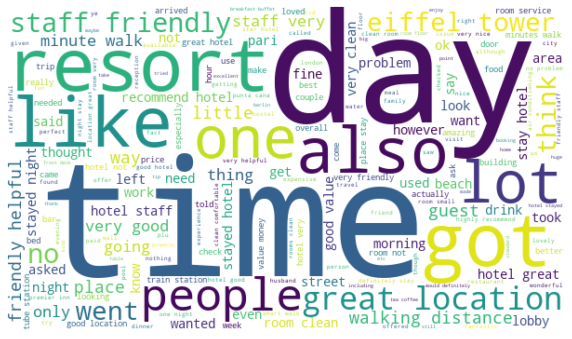

In [20]:
# Wordcloud
create_wordcloud(df['Review'], stop_words)

From the wordcloud, we can see that there may be many common words that do not help in determining the rating related to the review. We will deal with this later.

First, let's have a look at the length of all of our reviews by word count.

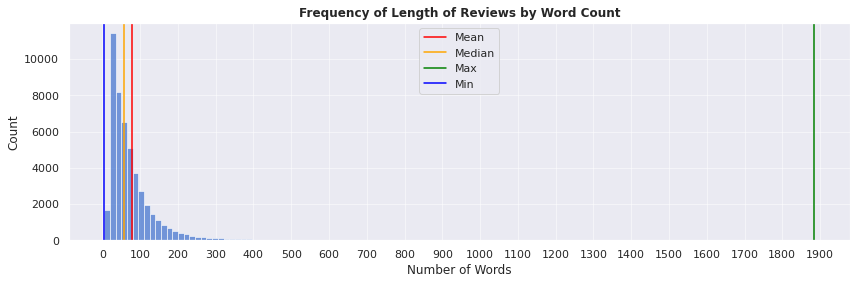

In [21]:
# Plot length of reviews by word count
plot_word_count(df['Review'], bins=125, max_x=2000, xtick_dist=100)

In [22]:
# See specific values for min, mean, median and max
review_length = [len(x.split()) for x in df['Review']]
print('Reviews')
print('-'*27)
print(f'Min length:\t    {np.min(review_length)} words')
print(f'Mean length:\t   {np.mean(review_length):.0f} words')
print(f'Median length:\t   {np.median(review_length):.0f} words')
print(f'Max length:\t {np.max(review_length)} words')

Reviews
---------------------------
Min length:	    5 words
Mean length:	   78 words
Median length:	   57 words
Max length:	 1885 words


Here, we can see that there is an outlier with a review length that is much longer than the other reviews. It looks like the majority of reviews are 300 words or less so we will remove any reviews which are more than 300 words long.

In [23]:
# Remove reviews which are over 300 words long
df = df[df['Review'].apply(lambda x: len(x.split()) <= 300)]

In [24]:
# Reset index
df = df.reset_index(drop=True)

Let's see what our distribution of review length is now that we have removed all reviews over 300 words long.

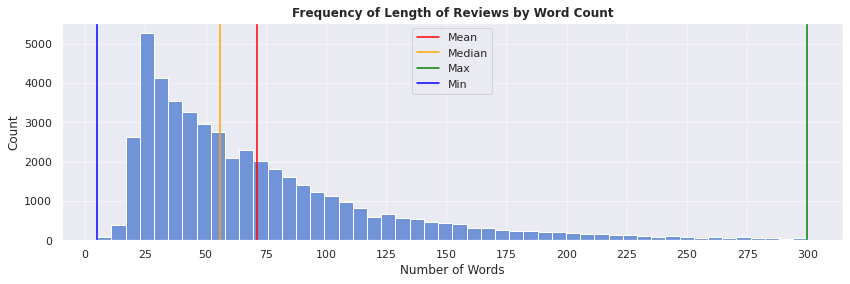

In [25]:
# Plot length of reviews by word count
plot_word_count(df['Review'], bins=50, max_x=301, xtick_dist=25)

In [27]:
# See specific values for min, mean, median and max
review_length = [len(x.split()) for x in df['Review']]
print('Reviews')
print('-'*27)
print(f'Min length:\t    {np.min(review_length)} words')
print(f'Mean length:\t   {np.mean(review_length):.0f} words')
print(f'Median length:\t   {np.median(review_length):.0f} words')
print(f'Max length:\t  {np.max(review_length)} words')

Reviews
---------------------------
Min length:	    5 words
Mean length:	   71 words
Median length:	   56 words
Max length:	  300 words


This looks much better although it still appears that the majority of reviews are less than 100 words long. Nevertheless, we will continue with what we currently have.

Let's have a look again at our class distribution.

In [28]:
# Rating score frequency
df['Rating'].value_counts()

5    18457
4    14718
3     6431
1     4211
2     3708
Name: Rating, dtype: int64

We still have a large class imbalance, so let's balance them before we move forward. We will take the class which has the lowest count, which in this case is class 2 with 3708 samples, and then randomly drop *n* samples (where *n* is the difference between 3708 and the current samples in the class) from the other classes so that they each only have 3708 samples remaining.

In [29]:
# Randomly drop all reviews above the minimum count (3708) to balance classes

# Create copy of original dataframe
df_bal = df.copy()

# Find the count of the class (rating) with the least instances: in this case there are only 3708 instances 
# for ratings with a score of 2
lowest_count = min(df_bal['Rating'].value_counts())

# Get all classes that have more than the min class
above_min = df_bal['Rating'].value_counts() > lowest_count
ratings_above_min = (above_min)[above_min].index.sort_values().tolist()

# Loop through classes that have more than the min class and randomly drop samples to balance all classes
for i in ratings_above_min:
    total_num = len(df_bal[df_bal['Rating'] == i]) - lowest_count
    df_bal = df_bal.drop(df_bal[df_bal['Rating'] == i].sample(n=total_num, random_state=42).index)
df_bal = df_bal.reset_index(drop=True)

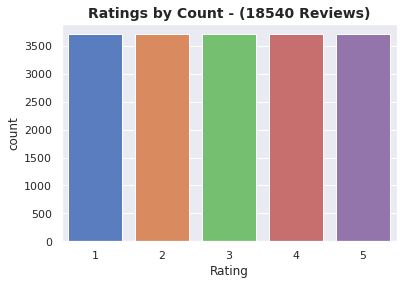

In [30]:
# Plot counts after removal
sns.countplot(x=df_bal['Rating'], zorder=2)
plt.title(f'Ratings by Count - ({df_bal.shape[0]} Reviews)', fontweight='bold', fontsize=14);

In [31]:
# Check value counts
df_bal['Rating'].value_counts()

5    3708
4    3708
3    3708
2    3708
1    3708
Name: Rating, dtype: int64

Now our classes are perfectly balanced.

In [32]:
# Check data
df_bal

,Review,Rating
0,ok nothing special charge diamond member hilto...,2
1,nice rooms not experience hotel monaco seattle...,3
2,excellent staff housekeeping quality hotel cho...,4
3,poor value stayed monaco seattle july nice hot...,2
4,nice hotel not nice staff hotel lovely staff q...,3
...,...,...
18535,dirty halls dirty rooms nothing works tv didn ...,1
18536,confortable rooms staff kind available polite ...,5
18537,stayed attending itb berlin heating system hot...,2
18538,hotel well located adenauerplatz ku damm reaso...,2


<a id="tokenization"></a>
### 4.1. Tokenization
---

Next, we will tokenize our reviews to help us understand more about them. Tokenization, splits the text up into individual items called tokens. In our case, this just splits reviews up into a list of words.

In [33]:
# Before Tokenization - example
df_bal['Review'][2]

'excellent staff housekeeping quality hotel chocked staff make feel home experienced exceptional service desk staff concierge door men maid service needs work maid failed tuck sheets foot bed instance soiled sheets used staff quickley resolved soiled sheets issue guess relates employee not reflection rest staff received excellent advice concierge regarding resturants area happy hour wine tasting nice touch staff went way make feel home great location like close good food shopping took play street theather well pikes market pioneer square access mono rail short walking distance'

In [34]:
# After tokenization - example
tokens = nltk.word_tokenize(df_bal['Review'][2])
print(tokens)

['excellent', 'staff', 'housekeeping', 'quality', 'hotel', 'chocked', 'staff', 'make', 'feel', 'home', 'experienced', 'exceptional', 'service', 'desk', 'staff', 'concierge', 'door', 'men', 'maid', 'service', 'needs', 'work', 'maid', 'failed', 'tuck', 'sheets', 'foot', 'bed', 'instance', 'soiled', 'sheets', 'used', 'staff', 'quickley', 'resolved', 'soiled', 'sheets', 'issue', 'guess', 'relates', 'employee', 'not', 'reflection', 'rest', 'staff', 'received', 'excellent', 'advice', 'concierge', 'regarding', 'resturants', 'area', 'happy', 'hour', 'wine', 'tasting', 'nice', 'touch', 'staff', 'went', 'way', 'make', 'feel', 'home', 'great', 'location', 'like', 'close', 'good', 'food', 'shopping', 'took', 'play', 'street', 'theather', 'well', 'pikes', 'market', 'pioneer', 'square', 'access', 'mono', 'rail', 'short', 'walking', 'distance']


Let's tokenize all of our reviews and add them into a separate column in our dataframe.

In [35]:
# Apply tokenization to all reviews
df_bal['tokenized'] = df_bal['Review'].apply(word_tokenize)

From here, we can also calculate word count for each review as well as the average word length.

In [36]:
# Calculate char_count, word_count, and avg_word_length
df_bal['word_count'] = df_bal['tokenized'].apply(lambda x: len(x))
df_bal['avg_word_length'] = df_bal['tokenized'].apply(lambda x: np.mean([len(word) for word in x]))

In [37]:
# Check data
df_bal.head()

,Review,Rating,tokenized,word_count,avg_word_length
0,ok nothing special charge diamond member hilto...,2,"[ok, nothing, special, charge, diamond, member...",240,5.737500
1,nice rooms not experience hotel monaco seattle...,3,"[nice, rooms, not, experience, hotel, monaco, ...",195,5.692308
2,excellent staff housekeeping quality hotel cho...,4,"[excellent, staff, housekeeping, quality, hote...",86,5.779070
3,poor value stayed monaco seattle july nice hot...,2,"[poor, value, stayed, monaco, seattle, july, n...",43,5.930233
4,nice hotel not nice staff hotel lovely staff q...,3,"[nice, hotel, not, nice, staff, hotel, lovely,...",64,5.031250


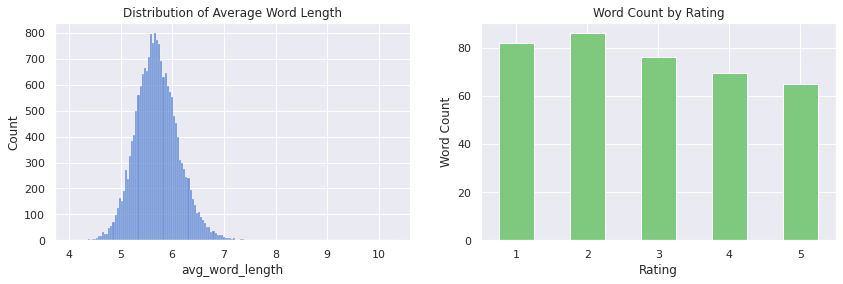

In [38]:
# Plot average word length
fig, axs = plt.subplots(1, 2, figsize=(14,4))

sns.histplot(df_bal['avg_word_length'], ax=axs[0])
axs[0].set_title('Distribution of Average Word Length')

df_bal.groupby('Rating')['word_count'].mean().plot(
    kind='bar', ylabel='Word Count', rot=0, cmap='Accent', ax=axs[1])
axs[1].set_title('Word Count by Rating');

From the distribution above, we can see that the average word length is between 5 and 7 and is normally distributed as we would expect. We can also see that the average word count by rating is usually between 60 and 90. What is interesting is that lower ratings tend to have more words per review. This could indicate that people who leave more negative reviews have more to say about their experiences than those who leave more positive reviews.

Now, let's plot the frequency of some of the most common words in our reviews and eliminate those which do not help in determining the rating.

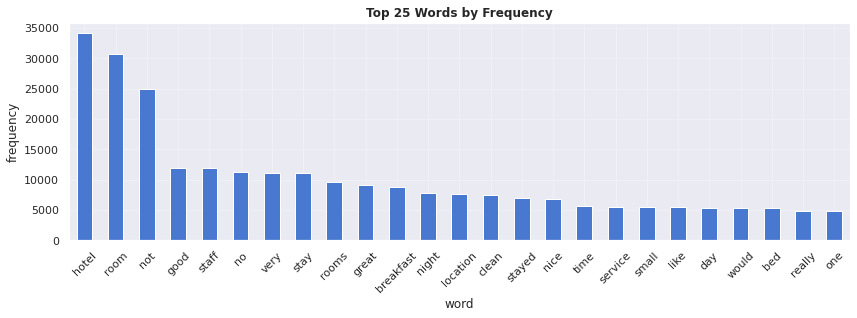

In [39]:
# Top 25 most common words
top_words(df_bal['Review'])

We can see that some of the most common words do not help in determining the rating for a review. For example, words such as 'hotel' and 'room' are likely to be used in reviews of all rating scores. Conversely, words such as great and clean could imply a certain sentiment that will help us to determine the rating of a review. We will cycle through the top most common words a few times, removing unecessary words as we go along.

In [40]:
# Remove unnecessary common words
new_stopwords = [
    'hotel', 'room', 'staff', 'stay', 'rooms', 'breakfast', 
    'night', 'location', 'stayed', 'time', 'day', 'bed', 'one'
]
stop_words.update(new_stopwords)
df_bal['Review'] = df_bal['Review'].apply(clean_reviews, args=(stop_words,))

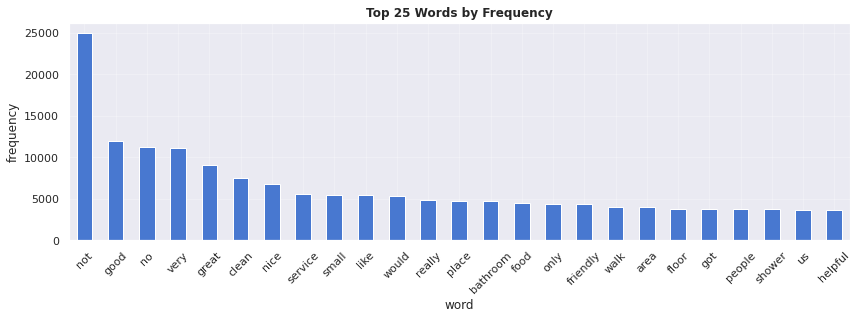

In [41]:
# Top 25 most common words
top_words(df_bal['Review'])

In [42]:
# Remove unnecessary common words
new_stopwords = ['place', 'bathroom', 'food', 'walk', 'area', 'floor', 'got', 'people', 'shower', 'us']
stop_words.update(new_stopwords)
df_bal['Review'] = df_bal['Review'].apply(clean_reviews, args=(stop_words,))

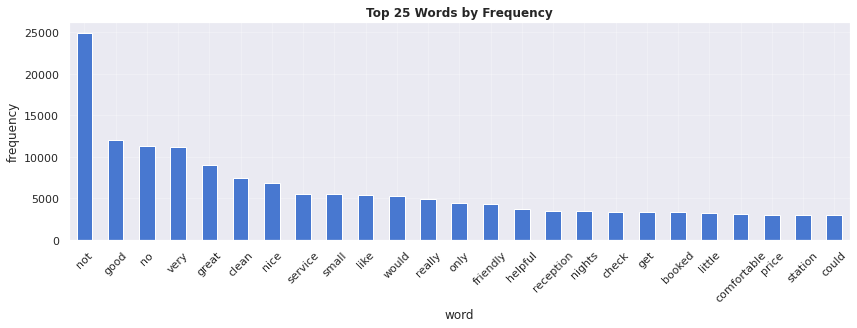

In [43]:
# Top 25 most common words
top_words(df_bal['Review'])

In [44]:
# Remove unnecessary common words
new_stopwords = ['reception', 'nights', 'check', 'get', 'booked', 'station']
stop_words.update(new_stopwords)
df_bal['Review'] = df_bal['Review'].apply(clean_reviews, args=(stop_words,))

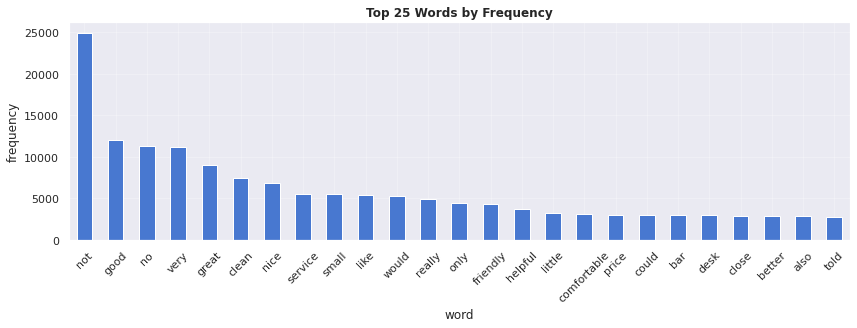

In [45]:
# Top 25 most common words
top_words(df_bal['Review'])

In [46]:
# Remove unnecessary common words
new_stopwords = ['bar', 'desk', 'also', 'told']
stop_words.update(new_stopwords)
df_bal['Review'] = df_bal['Review'].apply(clean_reviews, args=(stop_words,))

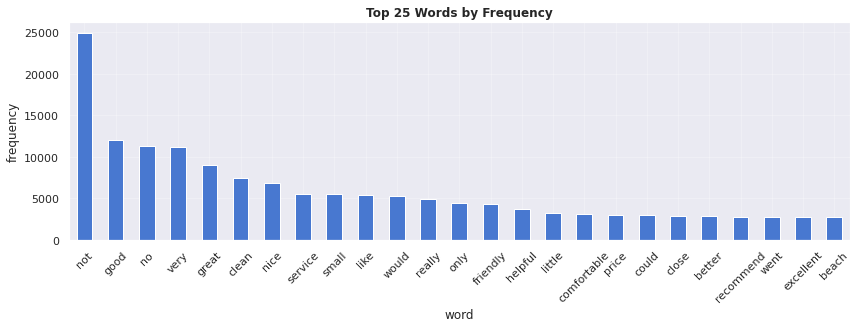

In [47]:
# Top 25 most common words
top_words(df_bal['Review'])

Now we have eliminated some of the most common and unnecessary words, let's save our stop words and generate another wordcloud.

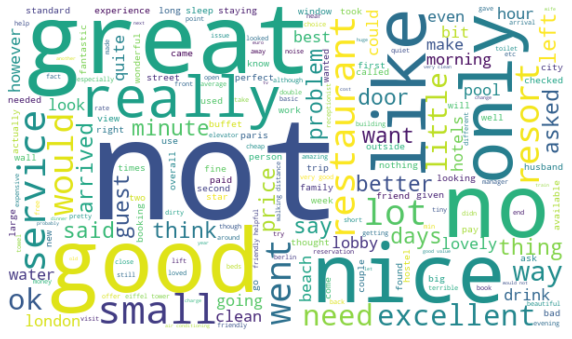

In [48]:
# Save final stop words
pickle.dump(stop_words, open('data/final_stop_words.pkl', 'wb'))

# Wordcloud
create_wordcloud(df_bal['Review'], stop_words)

This looks much better than what we had before.

<a id="lemmatization"></a>
### 4.1. Lemmatization
---

Now, let's go one step further and lemmatize our reviews. The process of lemmatization is when we take a word and covert it into its meaningful base form. For example, the words *runs*, *running* and *ran* are all forms of the base word *run* and thus are converted to this base form. Another similar method which is usually used is called stemming, which reduces words down to their stem, however, this stem may not always be a valid word in the language. An example of this is when the words *argue*, *argues* and *argued* are converted to their stem form *argu*. While stemming can be helpful, in this project, we will just stick to using lemmatization.

In [49]:
# Create lemmatizer object
lemma = WordNetLemmatizer()

In [50]:
# Lemmatize reviews
df_bal['Review'] = df_bal['tokenized'].apply(lambda x: ' '.join([lemma.lemmatize(word) for word in x]))

In [51]:
# Extract just feature and target
df_final = df_bal[['Review', 'Rating']]

In [52]:
# Check data after lemmatization
df_final

,Review,Rating
0,ok nothing special charge diamond member hilto...,2
1,nice room not experience hotel monaco seattle ...,3
2,excellent staff housekeeping quality hotel cho...,4
3,poor value stayed monaco seattle july nice hot...,2
4,nice hotel not nice staff hotel lovely staff q...,3
...,...,...
18535,dirty hall dirty room nothing work tv didn wor...,1
18536,confortable room staff kind available polite g...,5
18537,stayed attending itb berlin heating system hot...,2
18538,hotel well located adenauerplatz ku damm reaso...,2


We now have reviews which are clean, free from some of the most common words, and lemmatized. Let's save our data before we move on to the model building phase.

In [53]:
# Save DataFrame
df_final.to_csv('data/df_final.csv', index=False)

**[Back to Top](#top)**